In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox  
from osmnx import geocoder
import matplotlib.animation as animation
import random
import time

In [53]:
nodes = pd.read_csv('nodes.csv')
edges = pd.read_csv('edges.csv')
print(edges.head())
#fig, ax = ox.plot_graph(G)


        u           v  key       osmid   highway maxspeed              name  \
0  118725  2512504197    0  1355182986  tertiary       30  Banegårdspladsen   
1  118738  4924695592    0   699713642   service      NaN               NaN   
2  118744  1277939659    0   699713644   service      NaN               NaN   
3  118744  1277939659    1   112439593   service      NaN               NaN   
4  118744  1277939654    0   112439593   service      NaN               NaN   

   oneway reversed     length  \
0   False    False  14.315994   
1   False     True  11.838357   
2   False    False  15.868216   
3   False     True  99.070859   
4   False    False  64.339114   

                                            geometry        service bridge  \
0  LINESTRING (12.5629097 55.6739757, 12.5629715 ...            NaN    NaN   
1  LINESTRING (12.5618351 55.6628366, 12.5617904 ...            NaN    NaN   
2  LINESTRING (12.5600339 55.6617175, 12.5601929 ...  parking_aisle    NaN   
3  LINESTRING 

In [54]:
G = ox.load_graphml('graph.graphml')
print(G)

MultiDiGraph with 37113 nodes and 102980 edges


In [55]:
def plot_path(G, path):

    route_x, route_y = zip(*[(G.nodes[node]["x"], G.nodes[node]["y"]) for node in path])


    padding = 0.001 
    x_min, x_max = min(route_x) - padding, max(route_x) + padding
    y_min, y_max = min(route_y) - padding, max(route_y) + padding

    fig, ax = plt.subplots(figsize=(8, 8))

    ox.plot_graph(G, ax=ax, show=False, close=False, bgcolor='white')
    ax.plot(route_x[0], route_y[0], color='yellow', linewidth=5, marker='o')
    ax.plot(route_x[-1], route_y[-1], color='yellow', linewidth=5, marker='*')
    ax.plot(route_x, route_y, color='red')
    ax.set_xlim(x_min, x_max) 
    ax.set_ylim(y_min, y_max)
    plt.show()

def plot_multi_path(G, paths):
    fig, ax = plt.subplots(figsize=(8, 8))
    ox.plot_graph(G, ax=ax, show=False, close=False, bgcolor='white')

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, path in enumerate(paths):
        route_x, route_y = zip(*[(G.nodes[node]["x"], G.nodes[node]["y"]) for node in path])
        
        color = colors[i % len(colors)]
        
        ax.plot(route_x, route_y, color=color, label=f'Path {i+1}')
    ax.plot(route_x[0], route_y[0], color='yellow', linewidth=5, marker='o')
    ax.plot(route_x[-1], route_y[-1], color='yellow', linewidth=5, marker='*')
    ax.legend()
    ax.set_xlim(min(route_x) - 0.001, max(route_x) + 0.001)
    ax.set_ylim(min(route_y) - 0.001, max(route_y) + 0.001)
    plt.show()

def find_neighbors(G, node_id):
    ''' 
    This function returns a list with the ids of the neighbors of a node.

    Arguments:
        - G: a graph object
        - node_id: the id of the node to find the neighbors of

    Returns:
        - neighbors: a list with the ids of the neighbors of the node

    '''
    neighbors = []
    for neighbor in G.neighbors(node_id):
        neighbors.append(neighbor)

    if len(neighbors) == 0:
        print('Node has no neighbors')
    return np.array(neighbors)


def real_dist_nodes( edges, node1_id, node2_id):
    '''  
    This function returns a the distance between two connected nodes.

    Arguments:
        - edges: edges data frame
        - node1_id: node 1 id
        - node2_id: node 2 id

    Returns:
        - length: length between the connected nodes
    
    '''
    edge = edges[(edges['u'] == node1_id) & (edges['v'] == node2_id)]
    if not edge.empty:
        return edge.iloc[0]['length']
    else:
        print('Nodes are not connected')
        return None 


def euc_dist_nodes(G, edges, node1_id, node2_id):
    y1, x1, y2, x2 = [] , [], [], []

    for i in range(len(node1_id)):
        node_data = G.nodes[node1_id[i]]
        y1.append(node_data['y'])
        x1.append(node_data['x'])
    for j in range(len(node2_id)):
        node_data = G.nodes[node2_id[j]]
        y2.append(node_data['y'])
        x2.append(node_data['x'])
    y1, x1, y2, x2 = np.array(y1), np.array(x1), np.array(y2), np.array(x2)
    distance = ox.distance.euclidean(y1, x1, y2, x2)
    return distance**2
    

def distance_to_prob(dist):
    ''' 
    This function returns the probability of a path given the distance.

    Arguments:
        - dist: distance of the path

    Returns:
        - prob: normalized probability of the path

    '''
    prob = 1/dist
    return prob / np.sum(prob)

def length_population(G, pop):
    fitness = []
    for i in range(len(pop)):
        fitness.append(sum(G[u][v][0]['length'] for u, v in zip(pop[i][:-1], pop[i][1:])))
    return fitness

def find_path(G, edges, nodes, start_id, end_id):
    current_id = start_id
    path = [current_id]

    while current_id != end_id:
        neigh = find_neighbors(G, current_id)
        if len(neigh) == 0:
            #print('No neighbours found, terminating search.')
            break
        dist_to_end = euc_dist_nodes(G, edges, neigh, [end_id])

        if np.any(dist_to_end==0):
            #print('Path found!')
            path.append(end_id)
            break

        prob = distance_to_prob(dist_to_end)

        current_id = np.random.choice(neigh, p=prob)

        path.append(current_id)

    return np.array(path)


def populate(G, edges, nodes, start_id, end_id, num_pop):
    print(f'Populating with {num_pop} paths:')
    population= []
    for n in range(num_pop):
        path = find_path(G, edges, nodes, start_id, end_id)
        population.append(path)
        if n%(num_pop/4) == 0:
            print(f'Found {n} paths.')
    print(f'All {num_pop} paths found! \n')
    print('############### \n')
    return population

def best_survive(population , lengths, fraction) : 
    '''this function is getting a population and the lengths of the paths and returns the best fraction of the population'''
    sorted_indices = np.argsort(lengths)
    sorted_population = [population[i] for i in sorted_indices]
    survivors = int(fraction * len(population))

    survivors_pop = sorted_population[:survivors]
    return survivors_pop

def mutation(G,path):
    mnode = np.random.randint(1, len(path)-2)
    neigh = find_neighbors(G, path[mnode])
    possible_neighbors = [ n for n in neigh if G.has_edge(path[mnode-1], n) and G.has_edge(n, path[mnode+1])]

    if possible_neighbors:
        path[mnode] = random.choice(possible_neighbors)
    return path

def sex(parent1, parent2):
    common = list(set(parent1) & set(parent2))
    cnode = random.choice(common)

    idx1 = int(random.choice(np.where(parent1==cnode)[0]))
    idx2 = int(random.choice(np.where(parent2==cnode)[0]))

    if np.random.randint(0,2) == 0:
        child = np.concatenate((parent1[:idx1], parent2[idx2:]))
    else:
        child = np.concatenate((parent2[:idx2], parent1[idx1:]))
    
    if np.random.randint(0,101) < 10:
        child = mutation(G, child)

    return child


def evolution(nodestart, nodeend, generations, fraction, population_size, G= G, edges=edges, nodes=nodes ):
    '''This function is performing the genetic algorithm to find the best path between two nodes'''
    control = False
    convergency_generations = 10
    best_length = []
    survivors_pop = []
    population = populate(G, edges, nodes, nodestart, nodeend, population_size)
    lengths = length_population(G, population)
    survivors_pop = best_survive(population, lengths, fraction)
    best_length.append(min(lengths))
    for gen in range(generations):
        start = time.time()
        # Generate new population
        population = survivors_pop 
        while population_size > len(population):
            parent1, parent2 = random.sample(survivors_pop, 2)
            population.append(sex(parent1, parent2))
        
        #getting the best
        lengths = length_population(G, population)
        survivors_pop = best_survive(population, lengths, fraction)

        #saving stuff
        best_length.append(min(lengths))
        print('Generation', gen+1, "time for it : ", time.time()-start)
        print('Best length', best_length[-1])
        if len(best_length) > convergency_generations:
            for i in range(1, convergency_generations):
                if best_length[-i] != best_length[-i-1]:
                    control = False
                    break
                control = True
        if control : 
            print("Convergency reached")
            break

        
    best_path = survivors_pop[0]
    plot_path(G, best_path)
    return best_path, best_length



Populating with 1000 paths:
Found 0 paths.
Found 250 paths.
Found 500 paths.
Found 750 paths.
All 1000 paths found! 

############### 

Generation 1 time for it :  0.23817181587219238
Best length 2615.2898733013294
Generation 2 time for it :  0.19811201095581055
Best length 2210.591086646058
Generation 3 time for it :  0.16821813583374023
Best length 2210.591086646058
Generation 4 time for it :  0.14564919471740723
Best length 2210.591086646058
Generation 5 time for it :  0.13273310661315918
Best length 2210.591086646058
Generation 6 time for it :  0.11635708808898926
Best length 2210.591086646058
Generation 7 time for it :  0.10627913475036621
Best length 2210.591086646058
Generation 8 time for it :  0.09974789619445801
Best length 2140.321486495619
Generation 9 time for it :  0.08683586120605469
Best length 1855.6129586456718
Generation 10 time for it :  0.08392691612243652
Best length 1779.120776006315
Generation 11 time for it :  0.07569503784179688
Best length 1696.3581811540585
G

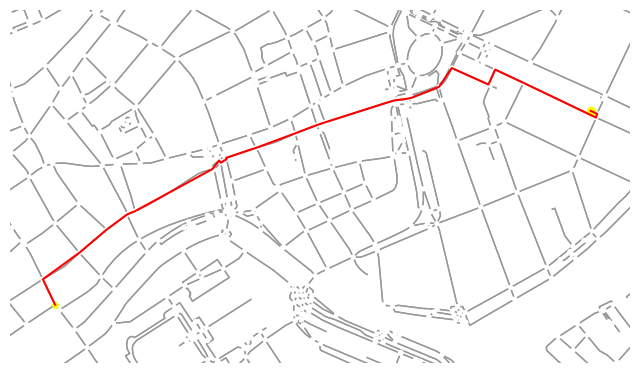

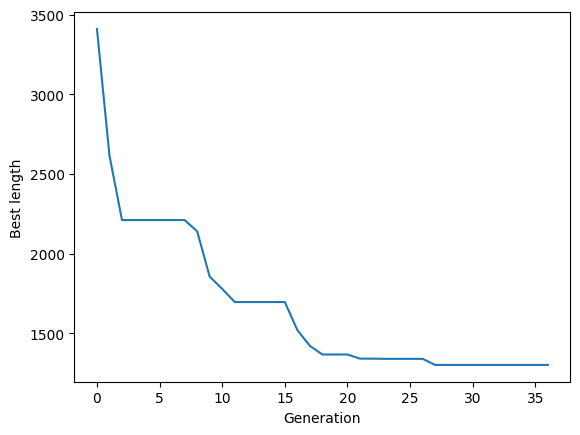

In [61]:
latstart, lonstart = ox.geocoder.geocode('Nyhavn, Copenhagen, Denmark')
nodestart = ox.distance.nearest_nodes(G, lonstart, latstart)
latend, lonend = ox.geocoder.geocode('Bastard Cafe, Copenhagen, Denmark')
nodeend = ox.distance.nearest_nodes(G, lonend, latend)

best_path, best_lengths = evolution(nodestart, nodeend, 100, 0.7, 1000)
plt.plot(best_lengths)
plt.xlabel('Generation')
plt.ylabel('Best length')
plt.show()